# cnn-feature-hierarhcy

In [1]:
import torch

def pick_device() -> torch.device:
    if torch.backends.mps.is_available():
        print("Using mps backend")
        return torch.device("mps")
    if torch.cuda.is_available():
        print("Using cuda backend")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        return torch.device("cuda")
    print('No GPU available, using the CPU.')
    return torch.device("cpu")

device = pick_device()  #torch.device("cpu")
pin_memory = True if device.type != 'cpu' else False

Using mps backend


# Dataset

In [2]:
from datasets import load_dataset, load_dataset_builder, DatasetDict, Dataset


DATASET = "cifar10"

ds_builder = load_dataset_builder(DATASET)
print("Features: ", ds_builder.info.features.keys())
labels = ds_builder.info.features['label']
print("Labels: ", labels.names)

train_dataset = load_dataset(DATASET, split="train")
val_dataset = load_dataset(DATASET, split="test")

Features:  dict_keys(['img', 'label'])
Labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


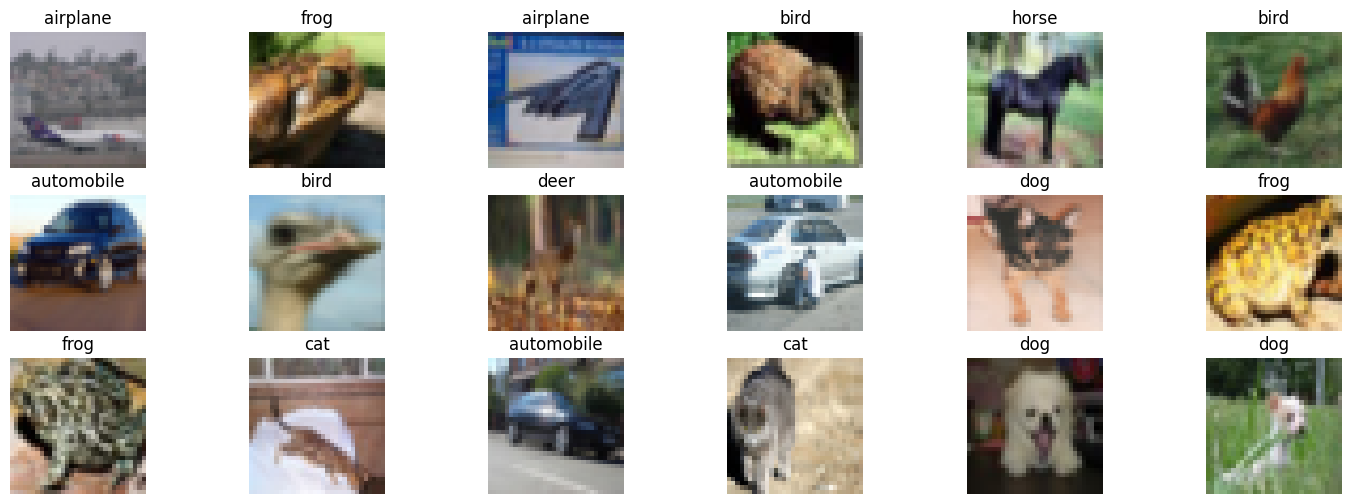

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

it = iter(train_dataset)

nrows, ncols = 3, 6
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
for i in range(0, nrows):
    for j in range(0, ncols):
        sample = next(it)
        ax =  axes[i][j]
        ax.axis('off')
        ax.set_title(labels.names[sample['label']])
        ax.imshow(sample['img'])
plt.show()

# Prepare Dataset

Using cache found in /Users/allen/.cache/torch/hub/pytorch_vision_v0.10.0


In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

MINI_BATCH_SZ = 16
NUM_CLASSES = len(labels.names)


# Format expected by ResNet https://pytorch.org/hub/pytorch_vision_resnet/
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def transform(item: dict) -> dict:
    item['img_tensor'] = preprocess(item['img'])
    return item


def data_loader(ds: Dataset) -> DataLoader:
    ds_xform = ds.map(transform)  #, batched=True)
    return DataLoader(
        ds_xform.with_format('torch'),
        batch_size=MINI_BATCH_SZ,
    )

tr_loader, val_loader = data_loader(train_dataset), data_loader(val_dataset)

# Training

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np

import time
from tqdm import tqdm


# Example using a pre-trained model with 1k classes
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
model = torchvision.models.resnet18(num_classes=NUM_CLASSES)
model.to(device)

lr = 0.01
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

10: 2.733 | 0.00
20: 3.248 | 0.00
30: 2.949 | 0.00
40: 3.009 | 0.00
50: 3.198 | 0.00
60: 2.658 | 0.00
70: 2.792 | 0.00
80: 2.887 | 0.00
90: 2.936 | 0.00
100: 2.592 | 0.00
110: 2.804 | 0.00
120: 3.058 | 0.00
130: 2.622 | 0.00
140: 2.573 | 0.00
150: 2.867 | 0.00
160: 2.373 | 0.00
170: 2.647 | 0.00
180: 2.503 | 0.00
190: 2.560 | 0.00
200: 2.682 | 0.00
210: 2.497 | 0.00
220: 2.336 | 0.00
230: 2.416 | 0.00
240: 2.204 | 0.00
250: 2.142 | 0.00
260: 2.183 | 0.00
270: 2.168 | 0.00
280: 2.505 | 0.00
290: 2.332 | 0.00
300: 2.151 | 0.00
310: 2.285 | 0.00
320: 2.113 | 0.00
330: 2.124 | 0.00
340: 2.599 | 0.00
350: 2.237 | 0.00
360: 2.474 | 0.00
370: 2.003 | 0.00
380: 1.980 | 0.00
390: 2.280 | 0.00
400: 2.204 | 0.00
410: 2.553 | 0.00
420: 2.245 | 0.00
430: 2.329 | 0.00
440: 2.079 | 0.00
450: 2.309 | 0.00
460: 2.309 | 0.00
470: 2.172 | 0.00
480: 2.173 | 0.00
490: 1.961 | 0.00
500: 1.965 | 0.00
510: 2.138 | 0.00
520: 2.405 | 0.00
530: 2.375 | 0.00
540: 2.308 | 0.00
550: 2.052 | 0.00
560: 2.306 | 0.00
5

In [48]:
def train(model: nn.Module, Xb: torch.tensor, Yb: torch.tensor) -> tuple[torch.tensor, torch.tensor, int, int]:
    # Put in format expected by resnet with (3, H, W). The 0 dimension
    # is the batch dimension so leave that alone.
    Xb = torch.permute(Xb, dims=(0, 3, 1, 2)).float()
    # Labels are a class integer. The model output contains one value
    # for the number of classes.
    label = Yb
    Yb = F.one_hot(Yb, num_classes=NUM_CLASSES).float()

    model.zero_grad()
    logits = model.forward(Xb)
    loss = F.cross_entropy(logits, Yb)
    loss.backward()

    with torch.no_grad():
        logits_classes = torch.argmax(logits, dim=1)
        total = Yb.size(0)
        correct = (logits_classes == label).sum().cpu()

    return (logits, loss, total, correct)


def evaluate(model: nn.Module, Xb: torch.tensor, Yb: torch.tensor) -> tuple[int, int]:
    """Process a training batch and return total and correct"""
    # Put in format expected by resnet with (3, H, W). The 0 dimension
    # is the batch dimension so leave that alone.
    Xb = torch.permute(Xb, dims=(0, 3, 1, 2)).float()
    # Labels are a class integer. The model output contains one value
    # for the number of classes.
    label = Yb
    Yb = F.one_hot(Yb, num_classes=NUM_CLASSES).float()

    logits = model.forward(Xb)
    loss = F.cross_entropy(logits, Yb)

    lossi.append(loss.item())

    logits_classes = torch.argmax(logits, dim=1)
    total = Yb.size(0)
    correct = (logits_classes == label).sum()
    return (total, correct)

In [54]:
for epoch in range(20):
    model.train()

    lossi: list[float] = []
    accuracyi: list[float] = []
    t0_epoch = time.time()

    pbar = tqdm(enumerate(tr_loader))
    #pbar = enumerate(tr_loader)

    with torch.enable_grad():

        for step, batch in pbar:
            Xb = batch['img'].to(device)
            Yb = batch['label'].to(device)

            logits, loss, total, correct = train(model, Xb, Yb)
            opt.step()

            lossi.append(loss.item())

            accuracy = (correct / total) * 100
            accuracyi.append(accuracy)


            if step > 0 and step % 10 == 0:
                #pbar.set_description(f"{step}: {loss.item():0.3f} | {accuracy:0.2f}")
                pbar.set_description(f"{step}: Loss: {np.mean(lossi[-10:]):0.3f} Accuracy: {np.mean(accuracyi[-10:]):0.2f}")
                pbar.update(1)

    break


140: Loss: 0.484 Accuracy: 85.00: : 148it [00:19,  7.70it/s]


KeyboardInterrupt: 

In [55]:

pbar = tqdm(enumerate(val_loader))
total = 0
correct = 0

model.eval()

with torch.no_grad():

    for step, batch in pbar:
        Xb = batch['img'].to(device)
        Yb = batch['label'].to(device)


        (t, c) = evaluate(model, Xb, Yb)
        total += t
        correct += c

        if step % 10 == 0:
            accuracy = (correct / total) * 100
            pbar.set_description(f"{accuracy:2.2f}% - {correct} of {total}")

60.45% - 1654 of 2736: : 173it [00:16, 10.76it/s]


KeyboardInterrupt: 

# Work Log

Training resnet model as an initial step of getting a working rig.
- After first training iteration: 51%
- After second training iteration: 59%

Note: Resnet-18 gets a top-1 accuracy 70% accuracy on imagenet 1k